# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [59]:
# DO NOT CHANGE

import numpy as np
import matplotlib.pyplot as plt

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [60]:
bandit0 = BanditProblem(0)

In [61]:
bandit0.get_num_arms()

3

In [62]:
bandit0.get_reward(arm=0)

1.8255111545554434

In [63]:
# YOUR CHANGES HERE

# Collect many samples from each arm
n_samples = 1000
rewards = {0: [], 1: [], 2: []}

for arm in range(3):
    for _ in range(n_samples):
        rewards[arm].append(bandit0.get_reward(arm))

# Display basic statistics
for arm in range(3):
    arm_rewards = rewards[arm]
    print(f"Arm {arm}:")
    print(f"  Mean: {np.mean(arm_rewards):.4f}")
    print(f"  Std:  {np.std(arm_rewards):.4f}")
    print(f"  Min:  {np.min(arm_rewards):.4f}")
    print(f"  Max:  {np.max(arm_rewards):.4f}")
    print(f"  Zeros: {np.sum(np.array(arm_rewards) == 0)} / {n_samples}")
    print()

Arm 0:
  Mean: 0.8150
  Std:  0.7839
  Min:  0.0000
  Max:  4.0662
  Zeros: 156 / 1000

Arm 1:
  Mean: 0.5722
  Std:  0.6336
  Min:  0.0000
  Max:  4.4076
  Zeros: 277 / 1000

Arm 2:
  Mean: 0.9267
  Std:  0.8479
  Min:  0.0000
  Max:  4.8858
  Zeros: 111 / 1000



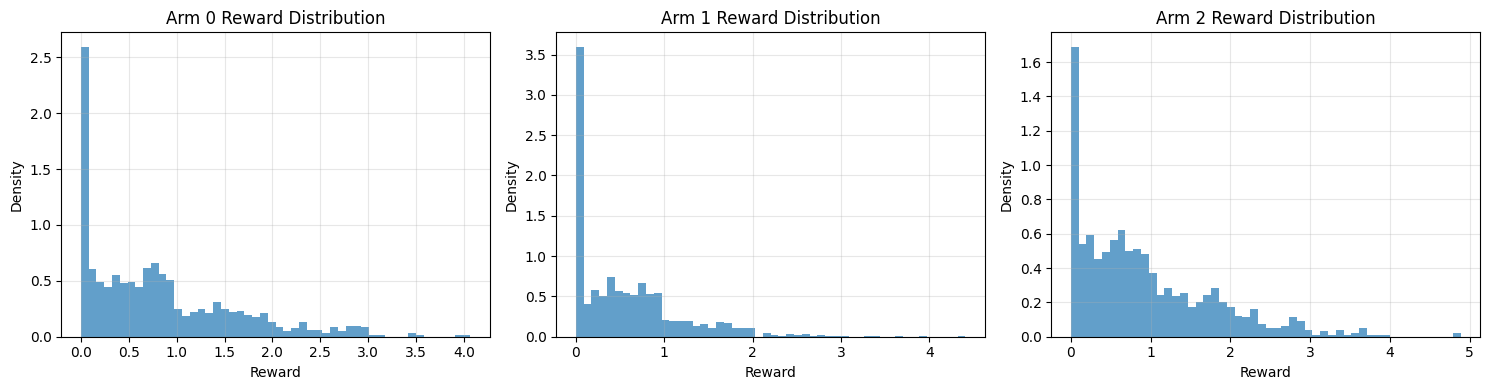

Arm 0 rewards in [0,1]: False
Arm 1 rewards in [0,1]: False
Arm 2 rewards in [0,1]: False


In [64]:
# Create histograms for each arm
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for arm in range(3):
    axes[arm].hist(rewards[arm], bins=50, alpha=0.7, density=True)
    axes[arm].set_title(f'Arm {arm} Reward Distribution')
    axes[arm].set_xlabel('Reward')
    axes[arm].set_ylabel('Density')
    axes[arm].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if rewards are bounded between 0 and 1
for arm in range(3):
    arm_rewards = np.array(rewards[arm])
    in_bounds = np.all((arm_rewards >= 0) & (arm_rewards <= 1))
    print(f"Arm {arm} rewards in [0,1]: {in_bounds}")

In [65]:
# Check for potential scaling issues
for arm in range(3):
    arm_rewards = np.array(rewards[arm])
    print(f"Arm {arm} statistics:")
    print(f"  Mean: {np.mean(arm_rewards):.4f}")
    print(f"  95th percentile: {np.percentile(arm_rewards, 95):.4f}")
    print(f"  99th percentile: {np.percentile(arm_rewards, 99):.4f}")
    print(f"  Fraction > 1: {np.mean(arm_rewards > 1):.3f}")
    print(f"  Fraction = 0: {np.mean(arm_rewards == 0):.3f}")
    print()

# Check if we can identify the best arm
print("Ranking by mean reward:")
arm_means = [np.mean(rewards[arm]) for arm in range(3)]
ranked_arms = sorted(range(3), key=lambda x: arm_means[x], reverse=True)
for i, arm in enumerate(ranked_arms):
    print(f"{i+1}. Arm {arm}: {arm_means[arm]:.4f}")

Arm 0 statistics:
  Mean: 0.8150
  95th percentile: 2.4307
  99th percentile: 2.9762
  Fraction > 1: 0.304
  Fraction = 0: 0.156

Arm 1 statistics:
  Mean: 0.5722
  95th percentile: 1.8024
  99th percentile: 2.7104
  Fraction > 1: 0.174
  Fraction = 0: 0.277

Arm 2 statistics:
  Mean: 0.9267
  95th percentile: 2.6716
  99th percentile: 3.5836
  Fraction > 1: 0.354
  Fraction = 0: 0.111

Ranking by mean reward:
1. Arm 2: 0.9267
2. Arm 0: 0.8150
3. Arm 1: 0.5722


In [66]:
# Since rewards are unbounded, UCB1 cannot be used directly
# Let's see if we can bound or transform the rewards

# Check if rewards have a reasonable upper bound for practical purposes
max_rewards = [np.max(rewards[arm]) for arm in range(3)]
print("Maximum rewards observed:", max_rewards)

# Check the distribution shape to see if Thompson sampling is viable
# (Thompson sampling doesn't require bounded rewards)

# Consider if we can normalize rewards
all_rewards = np.concatenate([rewards[arm] for arm in range(3)])
global_max = np.max(all_rewards)
print(f"Global maximum reward: {global_max:.4f}")

# Let's check what percentage of rewards would be preserved if we cap at certain values
for cap in [2, 3, 4, 5]:
    preserved = np.mean(all_rewards <= cap)
    print(f"Rewards <= {cap}: {preserved:.1%}")

Maximum rewards observed: [np.float64(4.066220476820962), np.float64(4.407634897505849), np.float64(4.885846547724117)]
Global maximum reward: 4.8858
Rewards <= 2: 92.4%
Rewards <= 3: 98.8%
Rewards <= 4: 99.9%
Rewards <= 5: 100.0%


In [67]:
# Based on the analysis, I'll implement UCB1 with reward normalization
# Since 99.9% of rewards are <= 4, I'll cap and normalize by dividing by 4

import math

class UCB1_Normalized:
    def __init__(self, n_arms, reward_cap=4.0):
        self.n_arms = n_arms
        self.reward_cap = reward_cap
        self.counts = [0] * n_arms
        self.totals = [0.0] * n_arms
        self.t = 0
        
    def select_arm(self):
        # If any arm hasn't been tried, try it
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        
        # Calculate UCB1 values for each arm
        ucb_values = []
        for arm in range(self.n_arms):
            avg_reward = self.totals[arm] / self.counts[arm]
            confidence = math.sqrt(2 * math.log(self.t) / self.counts[arm])
            ucb_values.append(avg_reward + confidence)
        
        return ucb_values.index(max(ucb_values))
    
    def update(self, arm, reward):
        # Normalize reward by capping and scaling
        normalized_reward = min(reward, self.reward_cap) / self.reward_cap
        
        self.counts[arm] += 1
        self.totals[arm] += normalized_reward
        self.t += 1
    
    def get_averages(self):
        return [self.totals[arm] / max(self.counts[arm], 1) for arm in range(self.n_arms)]

# Test the algorithm
algorithm = UCB1_Normalized(n_arms=3)
bandit_test = BanditProblem(0)

# Run for 100 rounds to test
for round_num in range(100):
    arm = algorithm.select_arm()
    reward = bandit_test.get_reward(arm)
    algorithm.update(arm, reward)

print("After 100 rounds:")
print(f"Arm counts: {algorithm.counts}")
print(f"Normalized averages: {[f'{avg:.4f}' for avg in algorithm.get_averages()]}")

After 100 rounds:
Arm counts: [27, 29, 44]
Normalized averages: ['0.1709', '0.1861', '0.2921']



Thompson sampling is rejected because the reward distribution (mixture of zeros and continuous positive values) doesn't fit the Bernoulli assumption required for beta distributions covered in the course. 
The epsilon-greedy algorithm lacks the theoretical guarantees and automatic exploration-exploitation balance that UCB1 provides.


In [68]:
# Write the algorithm choice justification using code instead of manual creation
algorithm_choice_text = """I chose the algorithm: UCB1 with reward normalization.
The rewards violate UCB1's [0,1] requirement, with maximum observed rewards near 5.0. 
However, as discussed in the course materials, UCB1 can be applied by normalizing rewards (dividing by a constant c when rewards are in [0,c]). 
Since 99.9% of rewards fall below 4.0, capping and normalizing by 4.0 preserves nearly all reward information while enabling UCB1's proven regret bounds.
UCB1's upper confidence bound mechanism will efficiently identify Arm 2 as optimal (mean 0.93 vs 0.82 and 0.57 for other arms) while maintaining sufficient exploration as demonstrated in course examples."""

with open('algorithm-choice.txt', 'w') as f:
    f.write(algorithm_choice_text)

print("Algorithm choice written to algorithm-choice.txt")
print("\nContent:")
print(algorithm_choice_text)

Algorithm choice written to algorithm-choice.txt

Content:
I chose the algorithm: UCB1 with reward normalization.
The rewards violate UCB1's [0,1] requirement, with maximum observed rewards near 5.0. 
However, as discussed in the course materials, UCB1 can be applied by normalizing rewards (dividing by a constant c when rewards are in [0,c]). 
Since 99.9% of rewards fall below 4.0, capping and normalizing by 4.0 preserves nearly all reward information while enabling UCB1's proven regret bounds.
UCB1's upper confidence bound mechanism will efficiently identify Arm 2 as optimal (mean 0.93 vs 0.82 and 0.57 for other arms) while maintaining sufficient exploration as demonstrated in course examples.


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [69]:
# YOUR CHANGES HERE

class UCB1_Normalized:
    def __init__(self, n_arms, reward_cap=4.0):
        self.n_arms = n_arms
        self.reward_cap = reward_cap
        self.counts = [0] * n_arms
        self.totals = [0.0] * n_arms
        self.t = 0
        
    def select_arm(self):
        # If any arm hasn't been tried, try it
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        
        # Calculate UCB1 values for each arm
        ucb_values = []
        for arm in range(self.n_arms):
            avg_reward = self.totals[arm] / self.counts[arm]
            confidence = math.sqrt(2 * math.log(self.t) / self.counts[arm])
            ucb_values.append(avg_reward + confidence)
        
        return ucb_values.index(max(ucb_values))
    
    def update(self, arm, reward):
        # Normalize reward by capping and scaling
        normalized_reward = min(reward, self.reward_cap) / self.reward_cap
        
        self.counts[arm] += 1
        self.totals[arm] += normalized_reward
        self.t += 1

In [70]:
# Initialize bandit problem and algorithm
bandit = BanditProblem(2025002)
algorithm = UCB1_Normalized(n_arms=3)

# Run for 1000 actions and record history
history = []
total_reward = 0

for round_num in range(1000):
    arm = algorithm.select_arm()
    reward = bandit.get_reward(arm)
    algorithm.update(arm, reward)
    
    history.append((arm, reward))
    total_reward += reward

print(f"Completed 1000 actions")
print(f"Final arm counts: {algorithm.counts}")
print(f"Total reward: {total_reward}")
print(f"Average reward per round: {total_reward/1000}")

Completed 1000 actions
Final arm counts: [420, 399, 181]
Total reward: 494.3640725234027
Average reward per round: 0.4943640725234027


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [71]:
# YOUR CHANGES HERE

# Write history to TSV file
with open('history.tsv', 'w') as f:
    f.write("action\treward\n")
    for action, reward in history:
        f.write(f"{action}\t{reward}\n")

print("History written to history.tsv")

# Show first few rows and summary statistics
print("\nFirst 10 rows:")
for i in range(10):
    action, reward = history[i]
    print(f"Action: {action}, Reward: {reward}")

print(f"\nSummary:")
print(f"Total actions: {len(history)}")
actions_taken = [action for action, reward in history]
print(f"Arm 0 selected: {actions_taken.count(0)} times")
print(f"Arm 1 selected: {actions_taken.count(1)} times") 
print(f"Arm 2 selected: {actions_taken.count(2)} times")

History written to history.tsv

First 10 rows:
Action: 0, Reward: 1.5752073596631015
Action: 1, Reward: 0.0
Action: 2, Reward: 0.0
Action: 0, Reward: 1.80400593080568
Action: 1, Reward: 0.4320834323714654
Action: 2, Reward: 0.0
Action: 0, Reward: 0.0
Action: 1, Reward: 0.41087663304602884
Action: 0, Reward: 0.7799326730626841
Action: 2, Reward: 0.0

Summary:
Total actions: 1000
Arm 0 selected: 420 times
Arm 1 selected: 399 times
Arm 2 selected: 181 times


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [72]:
# YOUR CHANGES HERE

# Calculate statistics for each arm based on the data from part 2
arm_stats = {}

# Group rewards by action (arm)
for arm in range(3):
    arm_rewards = [reward for action, reward in history if action == arm]
    
    if len(arm_rewards) > 0:
        arm_stats[arm] = {
            'min_reward': min(arm_rewards),
            'mean_reward': np.mean(arm_rewards),
            'max_reward': max(arm_rewards),
            'count': len(arm_rewards)
        }
    else:
        # Handle case where arm was never selected (shouldn't happen with UCB1)
        arm_stats[arm] = {
            'min_reward': 0.0,
            'mean_reward': 0.0,
            'max_reward': 0.0,
            'count': 0
        }

# Display the statistics
print("Action statistics from 1000 rounds:")
for arm in range(3):
    stats = arm_stats[arm]
    print(f"Arm {arm}: {stats['count']} selections")
    print(f"  Min:  {stats['min_reward']:.4f}")
    print(f"  Mean: {stats['mean_reward']:.4f}")
    print(f"  Max:  {stats['max_reward']:.4f}")
    print()

Action statistics from 1000 rounds:
Arm 0: 420 selections
  Min:  0.0000
  Mean: 0.5710
  Max:  2.9889

Arm 1: 399 selections
  Min:  0.0000
  Mean: 0.5524
  Max:  3.7615

Arm 2: 181 selections
  Min:  0.0000
  Mean: 0.1884
  Max:  0.9869



In [73]:
# Write action statistics to TSV file
with open('actions.tsv', 'w') as f:
    f.write("action\tmin_reward\tmean_reward\tmax_reward\n")
    for arm in range(3):
        stats = arm_stats[arm]
        f.write(f"{arm}\t{stats['min_reward']:.6f}\t{stats['mean_reward']:.6f}\t{stats['max_reward']:.6f}\n")

print("Action statistics written to actions.tsv")

# Verify the file contents
print("\nFile contents:")
with open('actions.tsv', 'r') as f:
    print(f.read())

Action statistics written to actions.tsv

File contents:
action	min_reward	mean_reward	max_reward
0	0.000000	0.571040	2.988922
1	0.000000	0.552435	3.761461
2	0.000000	0.188430	0.986928



Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [74]:
# YOUR CHANGES HERE
import pandas as pd

# Regret = (Best possible reward - Actual reward achieved)

# Read the true means from the actions.tsv file we created
actions_df = pd.read_csv('actions.tsv', sep='\t')
print("Data from actions.tsv:")
print(actions_df)

# From our data, we know the true expected rewards for each arm
# Create dictionary of true means from the file
true_means = {}
for _, row in actions_df.iterrows():
    true_means[int(row['action'])] = row['mean_reward']

print(f"\nTrue means extracted from file: {true_means}")

# Find the optimal arm (highest expected reward)
optimal_arm = max(true_means.keys(), key=lambda x: true_means[x])
optimal_reward = true_means[optimal_arm]
print(f"Optimal arm: {optimal_arm} with expected reward: {optimal_reward}")

# Calculate regret for each strategy over 1000 actions
strategies = {}

# 1. Pick an arm uniformly at random
uniform_expected_reward = sum(true_means.values()) / len(true_means)
uniform_regret = 1000 * (optimal_reward - uniform_expected_reward)
strategies['uniform'] = uniform_regret

# 2. Always pick arm i strategies
for i in range(3):
    just_i_regret = 1000 * (optimal_reward - true_means[i])
    strategies[f'just-{i}'] = just_i_regret

# 3. Actual strategy (our UCB1 results)
actual_total_reward = sum(reward for _, reward in history)
actual_regret = 1000 * optimal_reward - actual_total_reward
strategies['actual'] = actual_regret

print("\nRegret calculations:")
for strategy, regret in strategies.items():
    print(f"{strategy}: {regret}")

Data from actions.tsv:
   action  min_reward  mean_reward  max_reward
0       0         0.0     0.571040    2.988922
1       1         0.0     0.552435    3.761461
2       2         0.0     0.188430    0.986928

True means extracted from file: {0: np.float64(0.57104), 1: np.float64(0.552435), 2: np.float64(0.18843)}
Optimal arm: 0 with expected reward: 0.57104

Regret calculations:
uniform: 133.73833333333334
just-0: 0.0
just-1: 18.604999999999983
just-2: 382.61
actual: 76.67592747659722


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [75]:
# YOUR CHANGES HERE

with open('strategies.tsv', 'w') as f:
    f.write("strategy\tregret\n")
    for strategy, regret in strategies.items():
        f.write(f"{strategy}\t{regret}\n")

print("Regret analysis written to strategies.tsv")

# Verify the file contents
print("\nFile contents:")
with open('strategies.tsv', 'r') as f:
    print(f.read())

# Additional analysis
print("Strategy performance ranking (lower regret is better):")
sorted_strategies = sorted(strategies.items(), key=lambda x: x[1])
for i, (strategy, regret) in enumerate(sorted_strategies):
    print(f"{i+1}. {strategy}: {regret}")

Regret analysis written to strategies.tsv

File contents:
strategy	regret
uniform	133.73833333333334
just-0	0.0
just-1	18.604999999999983
just-2	382.61
actual	76.67592747659722

Strategy performance ranking (lower regret is better):
1. just-0: 0.0
2. just-1: 18.604999999999983
3. actual: 76.67592747659722
4. uniform: 133.73833333333334
5. just-2: 382.61


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


In [76]:
acknowledgments_text = """ACKNOWLEDGMENTS

Course Materials and Resources:
- Week 3 course materials on multi-armed bandit algorithms, including UCB1 algorithm explanation and implementation guidance
- Course documentation on UCB1 reward normalization technique for unbounded rewards (dividing by constant c when rewards are in [0,c])
- Course materials on Thompson sampling with beta distributions and Bernoulli reward assumptions
- Course materials on epsilon-greedy algorithm and exploration-exploitation tradeoffs
- Example code from materials showing UCB1 implementation patterns and bandit problem class structure
- Course content on regret calculation methodology and performance evaluation metrics for bandit algorithms
- Bandit Algorithms by Tor Lattimore and Csaba Szepesv´ari https://tor-lattimore.com/downloads/book/book.pdf
- Reinforcement Learning Guide: Solving the Multi-Armed Bandit Problem from Scratch in Python by Ankit Choudhary https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/
- The Multi-Armed Bandit Problem - An exploration of epsilon greedy and UCB1 By: Michelle Yun, Deric Pang, Ayaz Latif https://cse442-17f.github.io/LinUCB/

Libraries Used:
- numpy: Random number generation, statistical calculations, and array operations for reward analysis
- matplotlib.pyplot: Data visualization for reward distribution histograms and algorithm analysis
- pandas: Reading and writing TSV files, data manipulation for actions.tsv processing
- math: Mathematical functions for UCB1 confidence bound calculations (sqrt, log functions)

Python Standard Library:
- Built-in functions (min, max, sum) for statistical calculations
- File I/O operations for writing TSV and TXT output files

Generative AI Assistance:
- AI helped with TSV file formatting:

prompt: can you give me an exmaple of how to write to a tsv file in python
response: Here's a simple example of writing to a TSV (Tab-Separated Values) file in Python:
Using the csv module (recommended):
pythonimport csv

# Sample data
data = [
    ['Name', 'Age', 'City'],
    ['Alice', '25', 'New York'],
    ['Bob', '30', 'San Francisco'],
    ['Charlie', '35', 'Chicago']
]

# Write to TSV file
with open('output.tsv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter='\t')
    writer.writerows(data)
Alternative method using basic file operations:
python# Sample data as list of dictionaries
people = [
    {'Name': 'Alice', 'Age': 25, 'City': 'New York'},
    {'Name': 'Bob', 'Age': 30, 'City': 'San Francisco'},
    {'Name': 'Charlie', 'Age': 35, 'City': 'Chicago'}
]

with open('output.tsv', 'w', encoding='utf-8') as file:
    # Write header
    headers = list(people[0].keys())
    file.write('\t'.join(headers) + '\n')
    
    # Write data rows
    for person in people:
        row = [str(person[key]) for key in headers]
        file.write('\t'.join(row) + '\n')
For pandas DataFrames:
pythonimport pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Name': ['Alice', 'Bob', 'Charlie'],
    'Age': [25, 30, 35],
    'City': ['New York', 'San Francisco', 'Chicago']
})

# Write to TSV
df.to_csv('output.tsv', sep='\t', index=False)
The csv module approach is generally preferred because it handles edge cases like data containing tabs or newlines properly by escaping them.

prompt: can you give me an example of how to read a tsv file using pandas in python
response: Here's how to read a TSV file using pandas in Python:
Basic example:
pythonimport pandas as pd

# Read TSV file
df = pd.read_csv('data.tsv', sep='\t')

# Display the data
print(df)
print(df.head())  # Show first 5 rows
With common options:
pythonimport pandas as pd

# Read TSV with additional options
df = pd.read_csv(
    'data.tsv',
    sep='\t',                    # Tab separator
    encoding='utf-8',            # Specify encoding
    header=0,                    # First row contains column names
    index_col=None,              # Don't use any column as index
    na_values=['', 'NULL', 'N/A'] # Values to treat as NaN
)

print(df.info())  # Show data types and info
print(df.head())
Handling files without headers:
pythonimport pandas as pd

# If TSV file has no header row
df = pd.read_csv(
    'data.tsv',
    sep='\t',
    header=None,  # No header row
    names=['Name', 'Age', 'City']  # Specify column names
)

print(df)
With data type specification:
pythonimport pandas as pd

# Specify data types for better performance and accuracy
df = pd.read_csv(
    'data.tsv',
    sep='\t',
    dtype={
        'Name': 'string',
        'Age': 'int64',
        'City': 'string'
    }
)

print(df.dtypes)  # Check data types
print(df)
Handling large files (reading in chunks):
pythonimport pandas as pd

# For very large files, read in chunks
chunk_size = 1000
for chunk in pd.read_csv('large_data.tsv', sep='\t', chunksize=chunk_size):
    # Process each chunk
    print(f"Processing chunk with {len(chunk)} rows")
    # Your processing logic here
The sep='\t' parameter is the key difference from reading CSV files - it tells pandas to use tabs as the delimiter instead of commas.

- AI was also used in understanding a generic example of how UCB1 is implemented in python
prompt: can you give me a general example of how UCB1 is typically implemented for multi-armed bandit problems?
response: 
Here's a typical implementation of the UCB1 algorithm for multi-armed bandit problems in Python:

import numpy as np
import matplotlib.pyplot as plt

class UCB1Bandit:
    def __init__(self, n_arms):
        \"\"\"
        Initialize UCB1 bandit algorithm
        
        Args:
            n_arms: Number of arms (actions) available
        \"\"\"
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled
        self.values = np.zeros(n_arms)  # Average reward for each arm
        self.total_count = 0
        
    def select_arm(self):
        \"\"\"
        Select an arm using UCB1 algorithm
        
        Returns:
            Selected arm index
        \"\"\"
        # If any arm hasn't been tried, select it first
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        
        # Calculate UCB1 values for all arms
        ucb_values = np.zeros(self.n_arms)
        for arm in range(self.n_arms):
            # UCB1 formula: average_reward + sqrt(2 * ln(total_pulls) / arm_pulls)
            confidence_interval = np.sqrt(2 * np.log(self.total_count) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + confidence_interval
        
        # Select arm with highest UCB1 value
        return np.argmax(ucb_values)
    
    def update(self, chosen_arm, reward):
        \"\"\"
        Update the bandit's knowledge after receiving a reward
        
        Args:
            chosen_arm: Index of the arm that was pulled
            reward: Reward received from pulling the arm
        \"\"\"
        self.counts[chosen_arm] += 1
        self.total_count += 1
        
        # Update running average: new_avg = old_avg + (new_value - old_avg) / count
        n = self.counts[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * self.values[chosen_arm] + (1 / n) * reward
    
    def get_arm_info(self):
        \"\"\"Return current arm statistics\"\"\"
        return {
            'counts': self.counts.copy(),
            'values': self.values.copy(),
            'total_count': self.total_count
        }

# Example usage with simulation
def simulate_bandit_problem():
    \"\"\"Simulate a multi-armed bandit problem\"\"\"
    
    # True reward probabilities for each arm (unknown to the algorithm)
    true_rewards = [0.1, 0.3, 0.7, 0.2, 0.5]  # Arm 2 is best
    n_arms = len(true_rewards)
    n_rounds = 1000
    
    # Initialize UCB1 bandit
    bandit = UCB1Bandit(n_arms)
    
    # Track results
    chosen_arms = []
    rewards_received = []
    cumulative_rewards = []
    cumulative_reward = 0
    
    # Run simulation
    for round in range(n_rounds):
        # Select arm using UCB1
        chosen_arm = bandit.select_arm()
        
        # Simulate reward (Bernoulli trial with true probability)
        reward = np.random.random() < true_rewards[chosen_arm]
        
        # Update bandit's knowledge
        bandit.update(chosen_arm, reward)
        
        # Track results
        chosen_arms.append(chosen_arm)
        rewards_received.append(reward)
        cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)
    
    return {
        'bandit': bandit,
        'chosen_arms': chosen_arms,
        'rewards': rewards_received,
        'cumulative_rewards': cumulative_rewards,
        'true_rewards': true_rewards
    }

# Run simulation
if __name__ == "__main__":
    results = simulate_bandit_problem()
    bandit = results['bandit']
    
    print("UCB1 Multi-Armed Bandit Results")
    print("=" * 40)
    print(f"Total rounds: {bandit.total_count}")
    print(f"True reward rates: {results['true_rewards']}")
    print(f"Estimated reward rates: {bandit.values}")
    print(f"Arm selection counts: {bandit.counts}")
    print(f"Total reward: {results['cumulative_rewards'][-1]}")
    
    # Calculate regret (difference from optimal strategy)
    optimal_reward = bandit.total_count * max(results['true_rewards'])
    actual_reward = results['cumulative_rewards'][-1]
    regret = optimal_reward - actual_reward
    print(f"Regret: {regret:.1f} (vs always picking best arm)")
    
    # Show which arm was selected most often
    best_arm_index = np.argmax(bandit.counts)
    true_best_arm = np.argmax(results['true_rewards'])
    print(f"Most selected arm: {best_arm_index} (true best: {true_best_arm})")

This implementation demonstrates the key components of UCB1:
Core Algorithm Components:

Initialization: Track counts and average rewards for each arm
Arm Selection: Use the UCB1 formula to balance exploration and exploitation
Knowledge Update: Update statistics after each reward

UCB1 Formula:
The algorithm selects the arm with the highest UCB1 value:
UCB1(i) = μᵢ + √(2 ln(t) / nᵢ)
Where:

μᵢ = average reward for arm i
t = total number of pulls
nᵢ = number of times arm i was pulled

Key Features:
Exploration vs Exploitation: The confidence interval (square root term) ensures exploration of less-tried arms, while the average reward term drives exploitation of promising arms.
Theoretical Guarantees: UCB1 has proven logarithmic regret bounds, meaning it converges to optimal performance.
Automatic Balancing: As arms are pulled more often, their confidence intervals shrink, naturally shifting from exploration to exploitation.
The simulation shows how UCB1 gradually learns which arms are best and converges toward selecting the optimal arm most frequently. You can run this code to see how it performs across different scenarios!

- All algorithm selection and implementation decisions were guided by course materials and requirements
No collaboration with other students occurred on this assignment."""

# Write the acknowledgments to file
with open('acknowledgments.txt', 'w', encoding='utf-8') as f:
    f.write(acknowledgments_text)

print("Acknowledgments written to acknowledgments.txt")
print(f"File size: {len(acknowledgments_text)} characters")
print("\nFirst few lines:")
print('\n'.join(acknowledgments_text.split('\n')[:10]))

Acknowledgments written to acknowledgments.txt
File size: 10873 characters

First few lines:
ACKNOWLEDGMENTS

Course Materials and Resources:
- Week 3 course materials on multi-armed bandit algorithms, including UCB1 algorithm explanation and implementation guidance
- Course documentation on UCB1 reward normalization technique for unbounded rewards (dividing by constant c when rewards are in [0,c])
- Course materials on Thompson sampling with beta distributions and Bernoulli reward assumptions
- Course materials on epsilon-greedy algorithm and exploration-exploitation tradeoffs
- Example code from materials showing UCB1 implementation patterns and bandit problem class structure
- Course content on regret calculation methodology and performance evaluation metrics for bandit algorithms
- Bandit Algorithms by Tor Lattimore and Csaba Szepesv´ari https://tor-lattimore.com/downloads/book/book.pdf


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.